<a href="https://colab.research.google.com/github/bachaudhry/FastAI-22-23/blob/main/course_part_2/01A_Stable_Diffusion_Under_the_Hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion - A Look Under the Hood**

I'll be attempting to better understand the mechanics of the Hugging Face diffusers library by re-creating [J. Whitaker's excellent run-through](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb).

In [1]:
# Installing requirements for this NB
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

In [9]:
from base64 import b64encode
from google.colab import userdata
userdata.get('HFtoken')

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# Setup for Vid display
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Warning suppression when loading CLIPTextModel
logging.set_verbosity_error()

# Choose cuda or cpu, since we won't be requiring mps
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Models

GPU memory is an ever present concern. Let's work with the suggested work arounds in the original notebook i.e.:
1. Switch to `fp16`
2. Experiment with attention slicing
3. Keep VAE on the CPU

In [10]:
# Autoencoder model for decoding latents into the image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",
                                    subfolder="vae")#, variant="fp16",
                                    #torch_dtype=torch.float16)

# Tokenizer and the text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")#,
                                          # variant="fp16")#,
                                          #torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")#.half() # convert to half precision

# UNet model to generate latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4",
                                            subfolder="unet")#, variant="fp16",
                                            #torch_dtype=torch.float16)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012,
                                 beta_schedule="scaled_linear",
                                 num_train_timesteps=1000)

# Loading components onto the GPU and CPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


## Running a Diffusion Loop

In [16]:
# Starting off with settings
prompt = ["An oil on canvas painting of a Peace Lily"]
height = 512                      # Default height of Stable Diffusion
width = 512                       # Default width
num_inference_steps = 30          # Number of denoising steps
guidance_scale = 7.5              # Scale for classifier-free guidance
generator = torch.manual_seed(32) # Seed generator for initial latent noise
batch_size = 1

In [17]:
# Prep Text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                       truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)

with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [18]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
  scheduler.set_timesteps(num_inference_steps)
  scheduler.timesteps = scheduler.timesteps.to(torch.float32) # Needs Altering due to memory issues.

set_timesteps(scheduler, num_inference_steps)

In [19]:
# Prep latents
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator = generator
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # This version introuces scaling

<ipython-input-19-742c79a3ec6c>:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

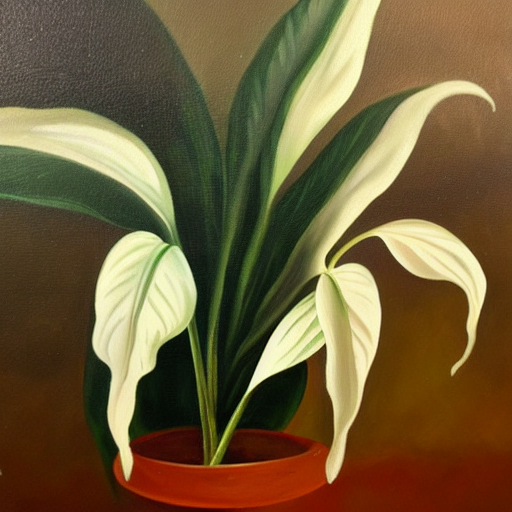

In [20]:
# Inference loop
with autocast("cuda"): # Reverts to CPU if there is no CUDA
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # Expand the latents if we are applying classifier free guidance to avoid two forward passes
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    # Scale the latents (pre-conditioning)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Scale and decode the image latents with vae
latents = 1 / 0.18215 * latents ## the scaling factor was implemented in the original paper.
with torch.no_grad():
  image = vae.decode(latents).sample

# Display output
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]
